In [1]:
import pandas as pd
import numpy as np
import collections
from sklearn.utils.linear_assignment_ import linear_assignment

import os

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg

## image preprocessing
import cv2
import albumentations as A
import imageio
from PIL import Image, ImageOps, ImageFilter
from IPython.display import display
from IPython.display import Image
from skimage.io import imread, imshow
from skimage import exposure
import matplotlib.pyplot as plt
from skimage.color import rgb2gray

from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL


## for metrics
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from coclust.evaluation.external import accuracy

## for clustering
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

pd.options.mode.chained_assignment = None  # default='warn'
import warnings
warnings.filterwarnings('ignore')

C:\Users\Troussard Family\anaconda3\lib\site-packages\sklearn\utils\linear_assignment_.py:18: FutureWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  warnings.warn(


# <span class="bg-primary">IMAGES Données visuelles : algorithmes SIFT et ORB<span>

# <span class="bg-danger">SOMMAIRE<span>

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

# <span class="bg-danger">Introduction<span>
    
__Buts de la mission:__

- Réaliser une première étude de faisabilité d'un moteur de classification d'articles basé sur une image et une description pour l'automatisation de l'attribution de la catégorie de l'article.

- Analyser le jeu de données en réalisant un prétraitement des images et des descriptions des produits, une réduction de dimension, puis un clustering.

__Contraintes:__
    
Mettre en œuvre a minima un __algorithme de type SIFT / ORB / SURF pour  extraire les features__  

# <span class="bg-danger">Pipeline<span>

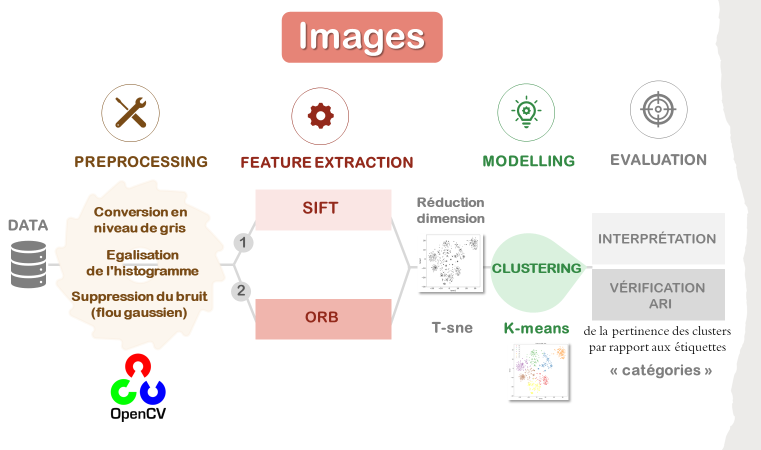

In [3]:
from pyquickhelper.helpgen import NbImage
NbImage("sift_orb_pipeline.png")

## <span class="bg-info"> 1. Chargement du jeu de données<span>

In [4]:
df = pd.read_csv('data/flipkart_com-ecommerce_sample_1050.csv')

In [5]:
def path(image):
    
    image = "Images/" + image
    
    return image

### <span class="bg-success"> 1.1 Exploration des images du jeu de données<span>  

In [6]:
# rajoutons les données images
df["image_manipulation"] = df["image"].copy()

# On reformate la colonne image de manière à avoir 
# le chemin complet des fichiers
df["image_manipulation"] = df["image_manipulation"].apply(path)

In [7]:
df_image = df[['image','image_manipulation', 'product_category_tree']]
df_image['cat_1']=df_image['product_category_tree'].apply(lambda x :x.split('>>')[0][2:len(x.split('>>')[0])-1])
del df_image['product_category_tree']

In [8]:
df_image.head()

image  \
0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3  d4684dcdc759dd9cdf41504698d737d8.jpg   
4  6325b6870c54cd47be6ebfbffa620ec7.jpg   

                            image_manipulation            cat_1  
0  Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing  
1  Images/7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care  
2  Images/64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care  
3  Images/d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing  
4  Images/6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing

In [9]:
df_image["cat_1"].reset_index().groupby("cat_1").count().sort_values(by= "index")

index
cat_1                            
Baby Care                     150
Beauty and Personal Care      150
Computers                     150
Home Decor & Festive Needs    150
Home Furnishing               150
Kitchen & Dining              150
Watches                       150

'Computers',#7   '#FF90A1', 
     'Baby Care', #8  '#EBBAB5',
     'Beauty and Personal Care',#9  '#8FF9FF'
     'Kitchen & Dining ',#10  '#FEF3C7',
     'Watches', #11  '#A6E3D7',
     'Home decor & Festive needs',#12  '#CBB4D5'
     'Home furnishing', #13  '#FFE18F'
      ]

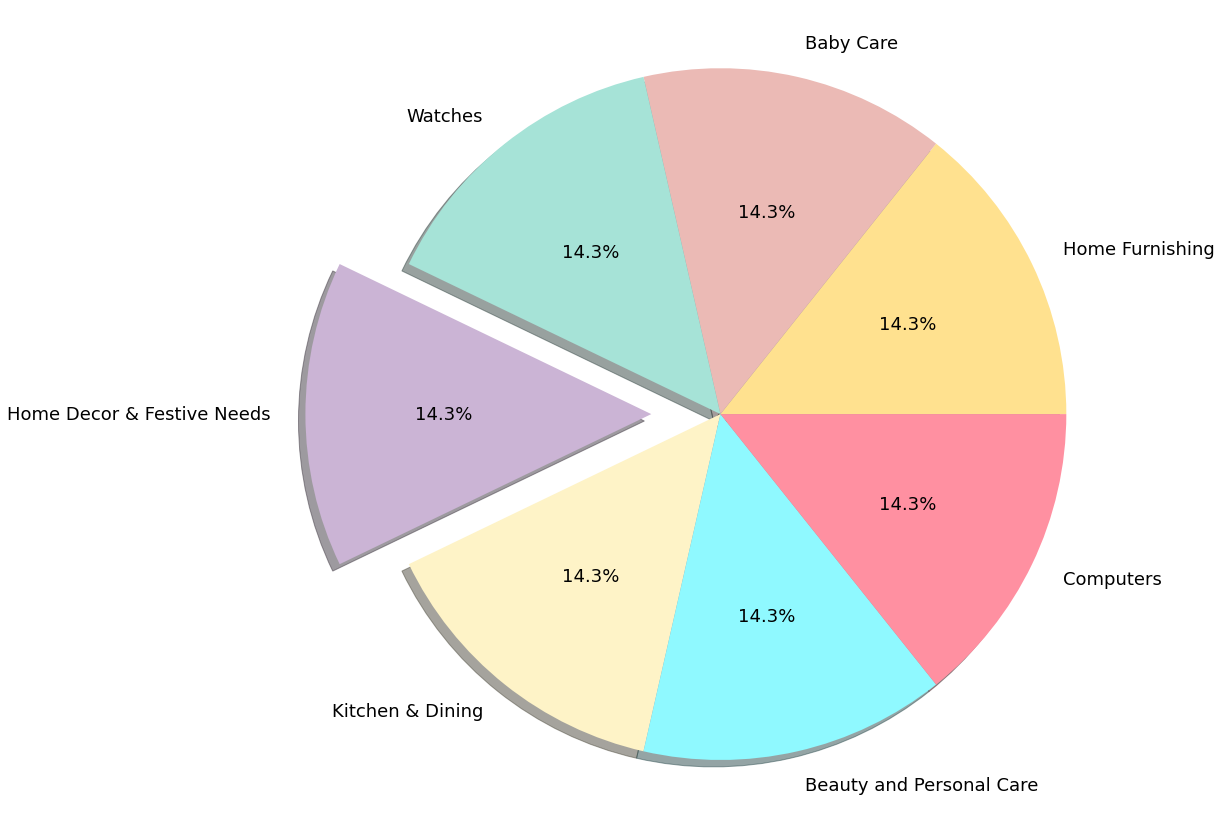

In [10]:
import matplotlib as mpl
mpl.rcParams['font.size'] = 18.0
nombre = collections.Counter(df_image['cat_1'])
sizes =[]
for valeur in nombre.values():
    sizes.append(valeur)
categories = df_image["cat_1"].unique()
plt.figure(figsize=(15, 15))
plt.pie(sizes,
        explode=(0, 0, 0, 0.2, 0, 0, 0) , 
        labels=categories,
        autopct='%1.1f%%',
        colors= ['#FFE18F', '#EBBAB5', '#A6E3D7','#CBB4D5', '#FEF3C7','#8FF9FF','#FF90A1'],
        shadow = True)
#plt.legend(loc = 'best',frameon = True, prop = {'size': 8}, title = 'Catégories', title_fontsize = 10 )
plt.axis('equal')
plt.show()    

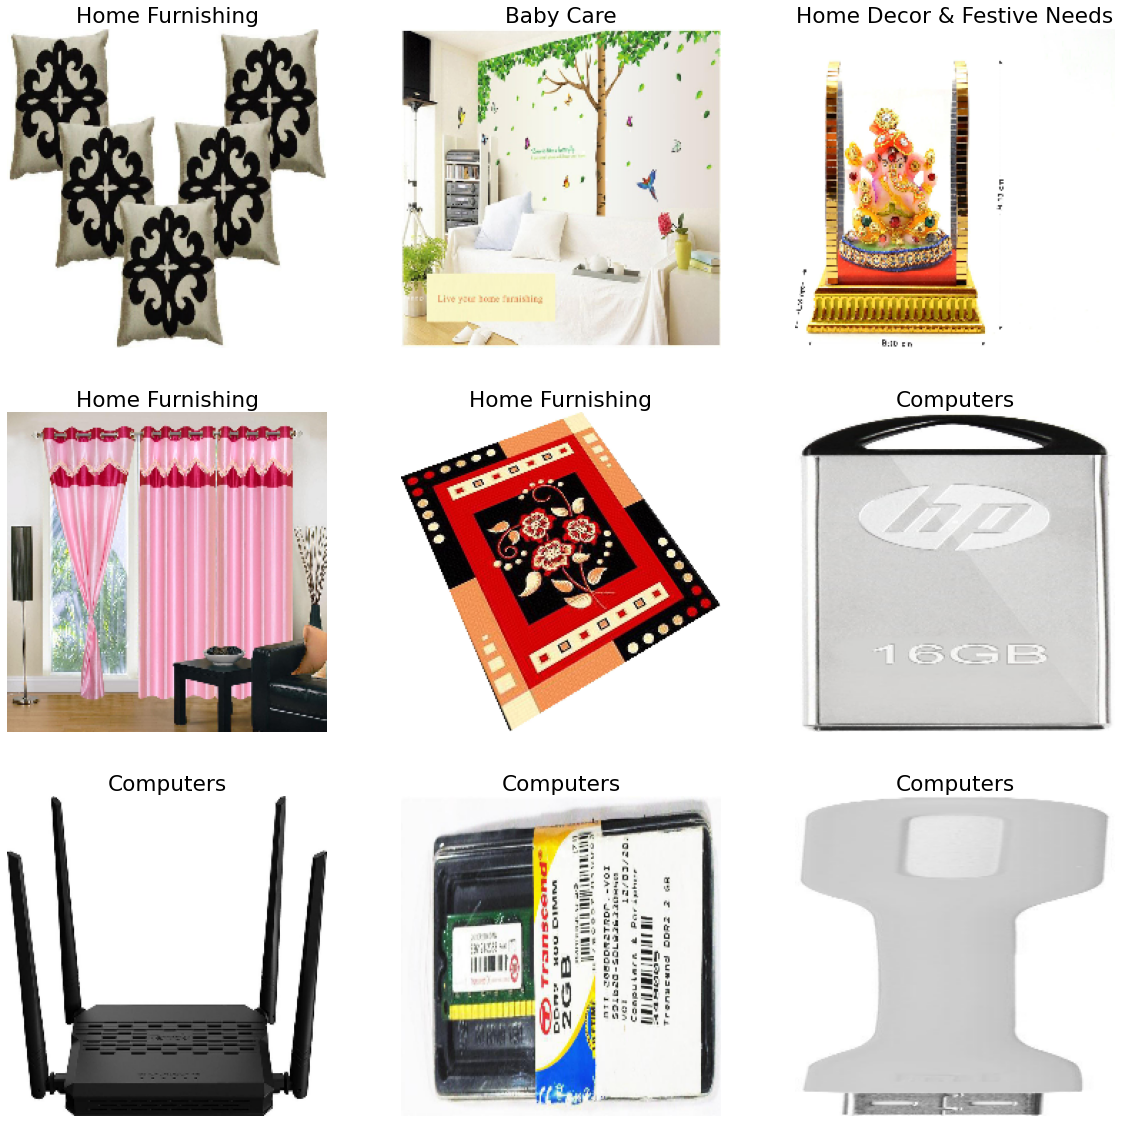

In [11]:
plt.figure(figsize=(20, 20))
df_visualisation = df_image.sample(9).reset_index(drop = True)

for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = mpimg.imread(df_visualisation["image_manipulation"][i])
    img = cv2.resize(img, (224, 224))
    plt.imshow(img)
    plt.title(df_visualisation["cat_1"][i])
    plt.axis("off")

### <span class="bg-success"> 1.2 Taille des images<span>  

#### Taille

In [12]:
#Largeur et longueur des 10 premières images du jeu de données
images =  df_image["image_manipulation"]
largeur = list()
hauteur = list()
for image in images:
    image = imageio.imread(image)
    taille = image.shape
    largeur.append(taille[0])
    hauteur.append(taille[1])
taille_images = pd.DataFrame({'Width': largeur, 'Heigth': hauteur})
taille_images.head(10)

Width  Heigth
0   3600    3600
1   1293    2388
2    729     982
3    831    1100
4   2088    2670
5   1770    1086
6   1593    1130
7   1000     651
8    510     318
9    784     416

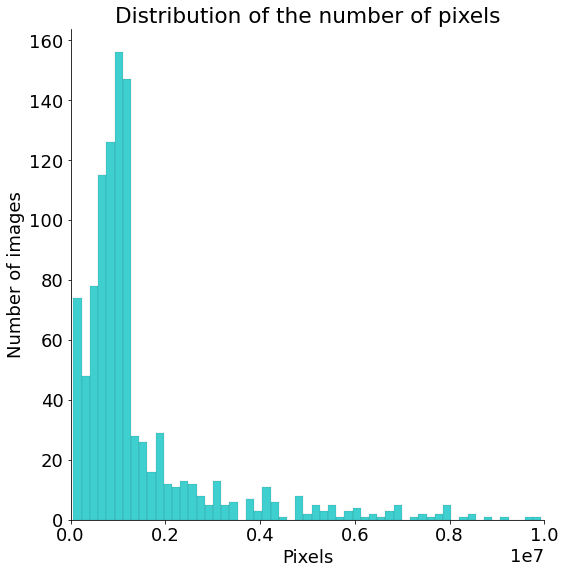

In [13]:
racine_tailles = taille_images.iloc[:, 0] * taille_images.iloc[:, 1]
# Plot histogram
sns.displot(racine_tailles, color='c', kde=False, height = 8)
plt.title("Distribution of the number of pixels")
plt.xlim(0,10000000)
plt.xlabel("Pixels")
plt.ylabel("Number of images")
plt.show()

#### Conclusions :

- Les images ont des tailles très variées. Nous allons les uniformiser en les redimmensionnant.
- Comme les réseaux neruronaux acceptent (par défaut) en entrée des images de 224x224, c'est à cette taille qu'il faudra redimensionner toutes les images.

## <span class="bg-info"> 2. Prétraitement et redimensionnement des images avec openCV<span>

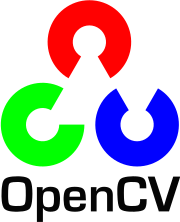

In [14]:
from pyquickhelper.helpgen import NbImage
NbImage("opencv.png")

#### Fonction Redimensionnement et prétraitement

In [15]:
def redimension(img): 
 
    width = 224
    height = 224
    dim = (width, height)
 
    # resize image
    img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
    
    return img

In [16]:
def process_image(image):
    
    file_dir=os.path.split(image)
    img = np.array(Image_PIL.open(image))
    
    # Conversion en niveau de gris de l'image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Suppression du bruit avec un kernel 
    img = cv2.GaussianBlur(img, (5, 5), cv2.BORDER_DEFAULT)
    
    # Egalisation de l'histogramme
    img = cv2.equalizeHist(img)
    
    # redimension
    img = redimension(img)
    
    #save image
    cv2.imwrite("Images_OCV/"+file_dir[1], img)
    
    return "Images_OCV/"+file_dir[1]

#### Exemple : redimensionnement et prétraitement sur une image du jeu de données

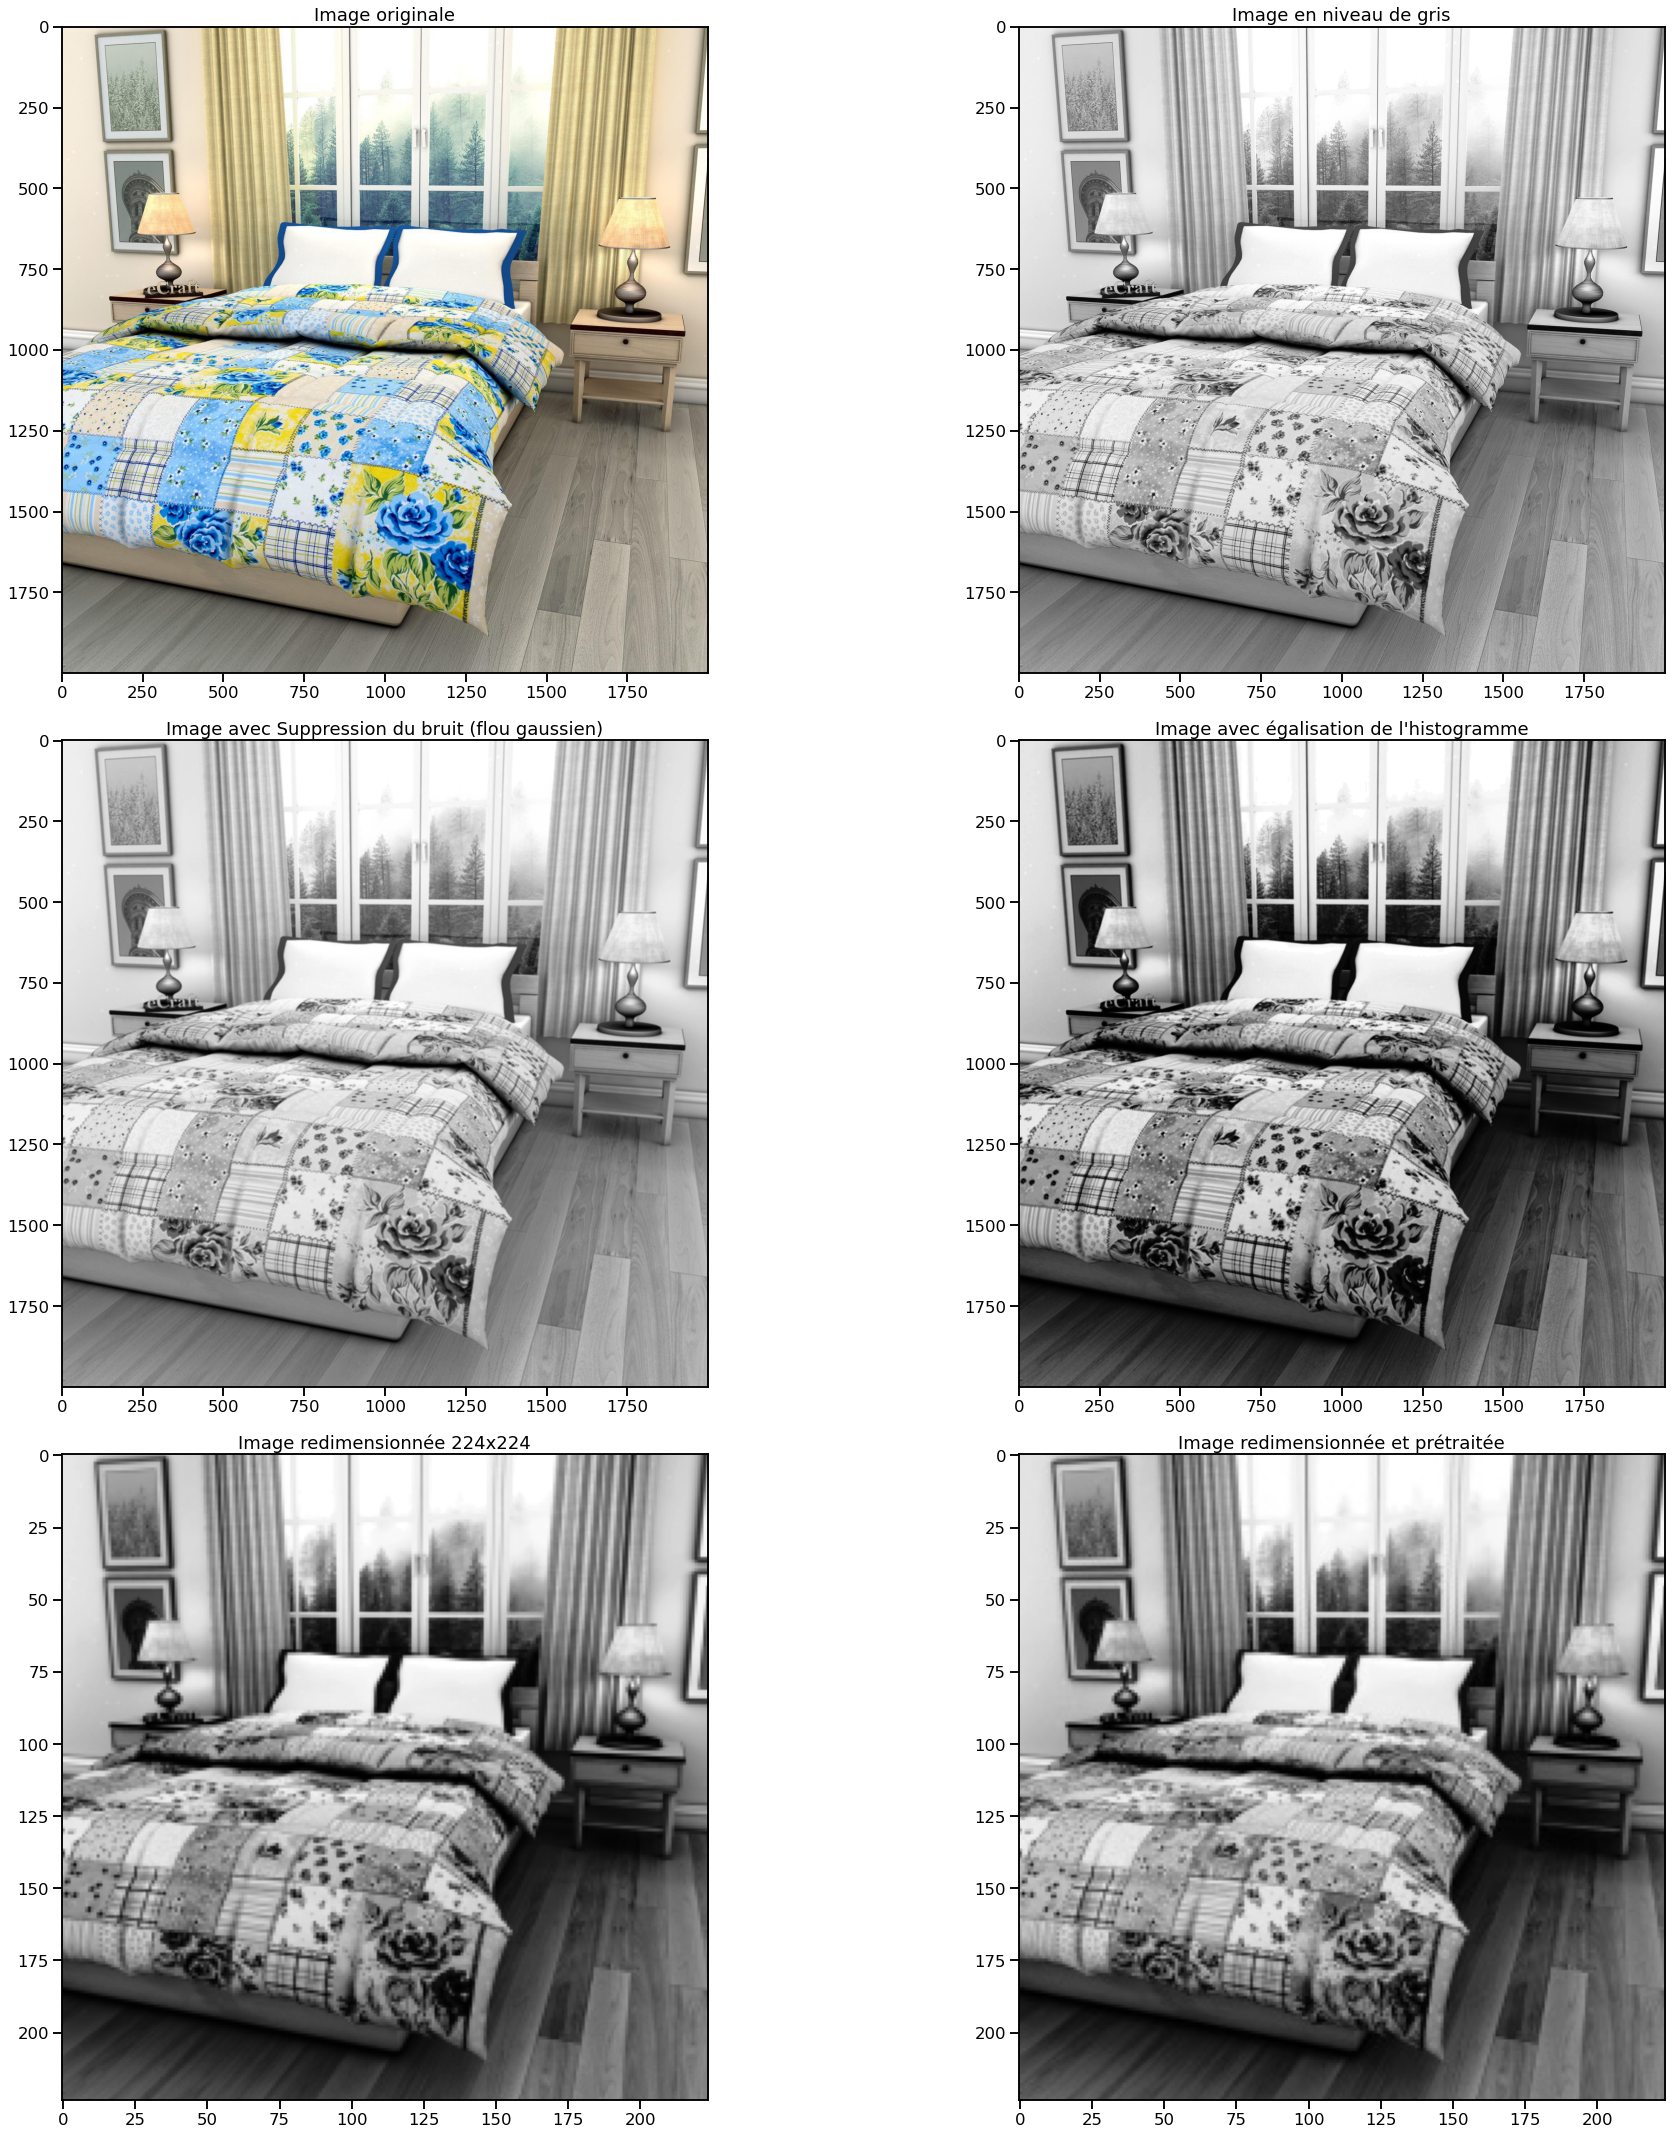

In [53]:
# print pictures

#Image originale du jeu de données
im = cv2.imread(df_image.image_manipulation[950])
im = im[:,:,::-1]

#Image convertie en niveau de gris
image = cv2.imread('Images/cd71b07a1d37a5e2cc04240e8498cc76.jpg')
# Convert the training image to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# Convert the training image to gray scale
im_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

#Image avec suppression du bruit (flou gaussien)
im_gaussblur =cv2.GaussianBlur(im_gray,(5,5),cv2.BORDER_DEFAULT)

#Image avec égalisation de l'histogramme
im_equalize = cv2.equalizeHist(im_gaussblur)

#Image redimensionnée en 224x224
im1 = redimension(im_equalize)

#Image finale, redimensionnée et prétraitée
process_image(df_image.image_manipulation[950])
im2 = cv2.imread('Images_OCV/cd71b07a1d37a5e2cc04240e8498cc76.jpg')

plt.figure(figsize=(30, 30))
plt.subplot(3, 2, 1)
plt.imshow(im, cmap="gray")
plt.title("Image originale", fontsize=18, ha='center' )

plt.subplot(3, 2, 2)
plt.imshow(im_gray, cmap="gray")
plt.title("Image en niveau de gris", fontsize=18, ha='center' )

plt.subplot(3, 2, 3)
plt.imshow(im_gaussblur, cmap="gray")
plt.title("Image avec Suppression du bruit (flou gaussien)", fontsize=18, ha='center' )

plt.subplot(3, 2, 4)
plt.imshow(im_equalize, cmap="gray")
plt.title("Image avec égalisation de l'histogramme", fontsize=18, ha='center' )

plt.subplot(3, 2, 5)
plt.imshow(im1, cmap="gray")
plt.title("Image redimensionnée 224x224", fontsize=18, ha='center' )

plt.subplot(3, 2, 6)
plt.imshow(im2, cmap="gray")
plt.title("Image redimensionnée et prétraitée", fontsize=18, ha='center' )
plt.tight_layout()

plt.show()

#### Redimensionnement sur l'ensemble des images du jeu de données

In [18]:
# Redimension en conservant les proportions d'origine de l'ensemble des images du jeu de données
df_image["image_OCV"] = df_image["image_manipulation"].apply(process_image)

## <span class="bg-info"> 3. Algorithmes SIFT et ORB<span>

#### Exemple : Descripteurs sur une image du jeu de données

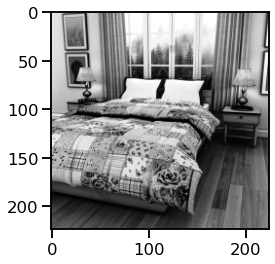

In [66]:
# Load the image
im = cv2.imread(df_image["image_OCV"][950])
plt.imshow(im)

In [67]:
# Change the array into image for treatment
im = np.array(im)

# Get descriptors and keypoints
sift = cv2.xfeatures2d.SIFT_create()
orb = cv2.ORB_create()
keypoints_sift, desc_sift = sift.detectAndCompute(im, None)
keypoints_orb, desc_orb = orb.detectAndCompute(im, None)

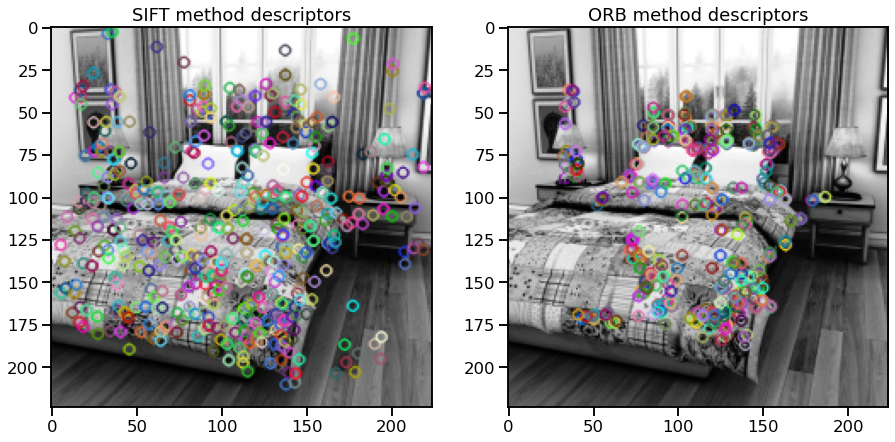

In [68]:
# print pictures
im_sift = cv2.drawKeypoints(im, keypoints_sift, None) 
im_orb = cv2.drawKeypoints(im, keypoints_orb, None) 

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(im_sift, cmap="gray")
plt.title("SIFT method descriptors")


plt.subplot(1, 2, 2)
plt.imshow(im_orb, cmap="gray")
plt.title("ORB method descriptors")

plt.show()

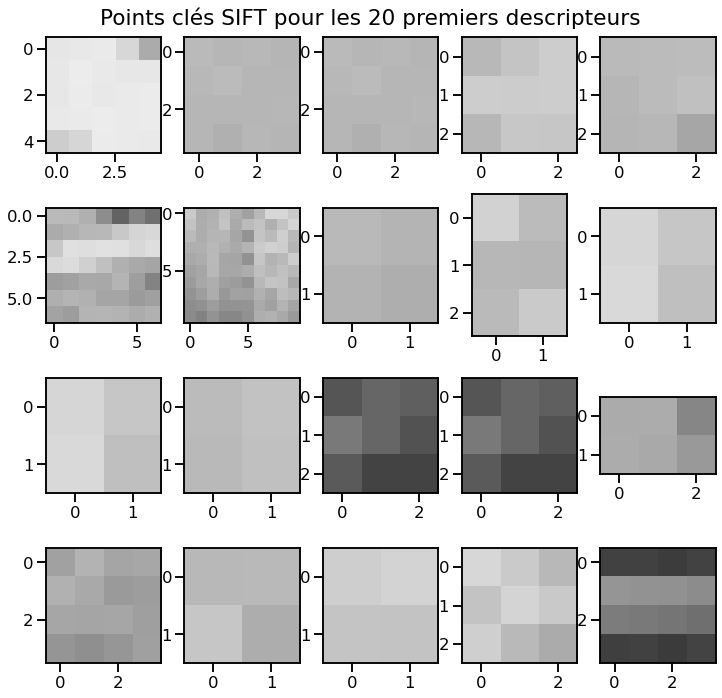

In [76]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle("Points clés SIFT pour les 20 premiers descripteurs", y=0.90)

for i, kp in enumerate(keypoints_sift[0:20]):
    # Get the coordinates of the center and size
    plt.subplot(4, 5, i + 1)
    x_center = kp.pt[0]
    y_center = kp.pt[1]
    size = kp.size

    # Set the border limits
    left = np.ceil(x_center - size / 2)
    upper = np.ceil(y_center + size / 2)
    right = np.ceil(x_center + size / 2)
    lower = np.ceil(y_center - size / 2)

    # Crop the image and show the parts
    cropped_np = np.array(im)[int(lower):int(upper), int(left):int(right)]
    plt.imshow(cropped_np, cmap="gray")
plt.show()

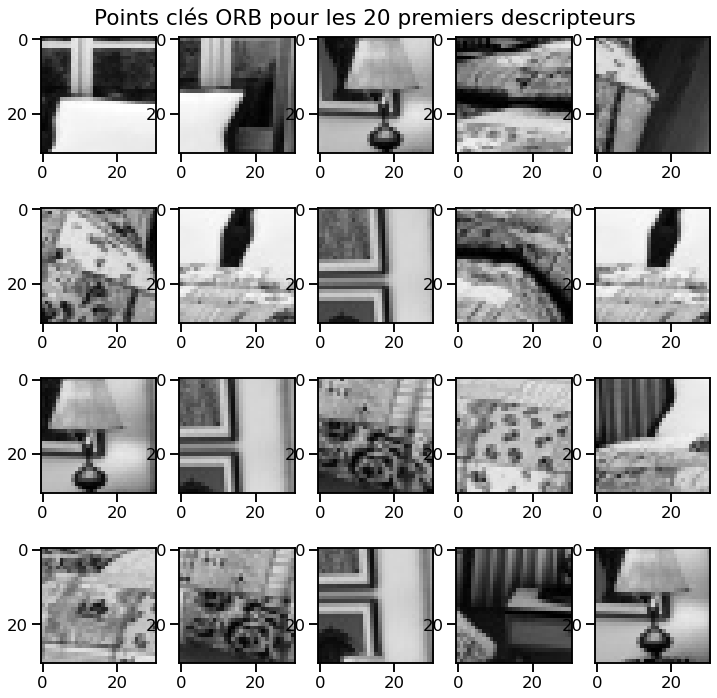

In [78]:
fig = plt.figure(figsize=(12, 12))
fig.suptitle('Points clés ORB pour les 20 premiers descripteurs', y=0.90)

for i, kp in enumerate(keypoints_orb[0:20]):
    # Get the coordinates of the center and size
    plt.subplot(4, 5, i + 1)
    x_center = kp.pt[0]
    y_center = kp.pt[1]
    size = kp.size

    # Set the border limits
    left = np.ceil(x_center - size / 2)
    upper = np.ceil(y_center + size / 2)
    right = np.ceil(x_center + size / 2)
    lower = np.ceil(y_center - size / 2)

    # Crop the image and show the parts
    cropped_np = np.array(im)[int(lower):int(upper), int(left):int(right)]
    plt.imshow(cropped_np, cmap="gray")
plt.show()

In [75]:
print("SIFT : {} descriptors of {} features".format(desc_sift.shape[0], desc_sift.shape[1]))
print("ORB : {} descriptors of {} features".format(desc_orb.shape[0],desc_orb.shape[1]))

SIFT : 534 descriptors of 128 features
ORB : 416 descriptors of 32 features


#### Fonctions utiles

In [22]:
def getDescriptors(detector, image):
    img = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    kp, des = detector.detectAndCompute(img, None)
    return des

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 

    return descriptors 

In [23]:
# Detector
orb = cv2.ORB_create(nfeatures=1500)
sift = cv2.xfeatures2d.SIFT_create()

In [24]:
def _make_cost_m(cm):
    s = np.max(cm)
    return (- cm + s)

#https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/
- L'accuracy_score fourni par scikit-learn est destiné à traiter les résultats de la classification, et non du clustering.
- L'accuracy du clustering peut être réalisée en réordonnant les lignes (ou les colonnes) de la matrice de confusion de sorte que __la somme des valeurs diagonales soit maximale.__
- La bibliothèque __Coclust__ fournit une implémentation de l'accuracy pour le résultat du clustering.

In [25]:
#https://smorbieu.gitlab.io/accuracy-from-classification-to-clustering-evaluation/
def heatconmat(y_true,y_pred):
    
    sns.set_context('talk')
    plt.figure(figsize=(9,6))
    cm = confusion_matrix(y_true,y_pred)
    #Hungarian algorithm
    indexes = linear_assignment(_make_cost_m(cm))
    js = [e[1] for e in sorted(indexes, key=lambda x: x[0])]
    cm2 = cm[:, js]
    sns.heatmap(cm2,
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(y_pred.unique()),
                xticklabels=sorted(y_true.unique()))
    plt.show()
    print('\naccuracy du clustering: {}%'.format(round(accuracy(y_true,y_pred)*100,2)))
    print('\naccuracy de la classification: {}%'.format(round(accuracy_score(y_true,y_pred)*100,2)))
    print(classification_report(y_true,y_pred))
   

### <span class="bg-success"> 3.1 Algorithme SIFT<span>  

#### <span class="bg-warning"> 3.1.1 Détection<span>  

In [26]:
# Descriptor_list
descriptor_list = []

images = df_image["image_OCV"]
lien_im_des = [] #lien image _ descripteur

for i in range(len(images)) :
    im = images[i]
    des = getDescriptors(sift, im)
    descriptor_list.append(des)
    
    # Lien image - descripteur
    for j in range(len(des)):
        lien_im_des.append(i)
    
descriptors = vstackDescriptors(descriptor_list)

#https://docs.opencv.org/master/d1/d5c/tutorial_py_kmeans_opencv.html
#samples : It should be of np.float32 data type, and each feature should be put in a single column.
descriptors = np.float32(descriptors)

#### <span class="bg-warning"> 3.1.1 Extraction<span>  

__K-means__

In [27]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_PP_CENTERS #kmeans++

# Apply KMeans
# attempt : Indicateur permettant de spécifier le nombre de fois que l'algorithme est exécuté en utilisant différents libellés
# initiaux. L'algorithme renvoie les étiquettes qui donnent la meilleure compacité (voir le dernier paramètre de la fonction).
compactness,labels,centers = cv2.kmeans(descriptors,1000,None,criteria,1,flags)

In [28]:
data_images = []
for i in range(len(images)):
    # create a numpy to hold the histogram for each image
    data_images.insert(i, np.zeros((1000, 1)))

__Histogramme__

In [29]:
# Histograms from labels
size = labels.shape[0] * labels.shape[1]
data_images = []
for i in range(len(images)):
    # create a numpy to hold the histogram for each image
    data_images.insert(i, np.zeros((1000, 1)))
    
#Bag of visual words with SIFT
df_image["BOVW_SIFT"] = ""
for i in range(size):
    label = labels[i]
    # Get this descriptors image id
    image_id = lien_im_des[i]
    # data_images is a list of the same size as the number of images
    images_data = data_images[image_id]
    # data is a numpy array of size (dictionary_size, 1) filled with zeros
    images_data[label] += 1
    df_image["BOVW_SIFT"][image_id] = images_data.flatten()

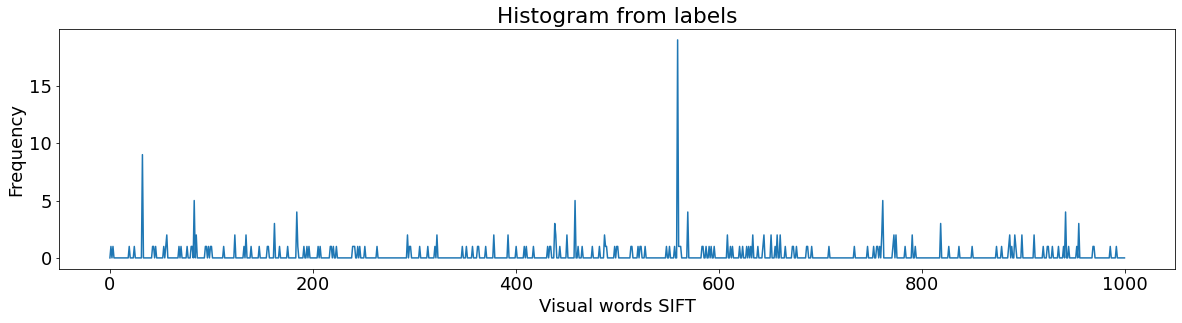

In [30]:
plt.figure(figsize=(20,15))
ax = plt.subplot(311)
ax.set_title("Histogram from labels")
ax.set_xlabel("Visual words SIFT")
ax.set_ylabel("Frequency")
ax.plot(data_images[1].ravel())

#### <span class="bg-warning"> 3.1.1 Reduction de dimension et clustering<span> 

In [31]:
def extract_data(col):
    v = np.column_stack(df_image[col].values.tolist())
    df = pd.DataFrame(v).T
    
    return df

In [32]:
df_BOVW_SIFT = extract_data("BOVW_SIFT")
print("Taille vecteurs bovw SIFT :", df_BOVW_SIFT.shape[1])

Taille vecteurs bovw SIFT : 1000


In [33]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_BOVW_SIFT)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

In [34]:
#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

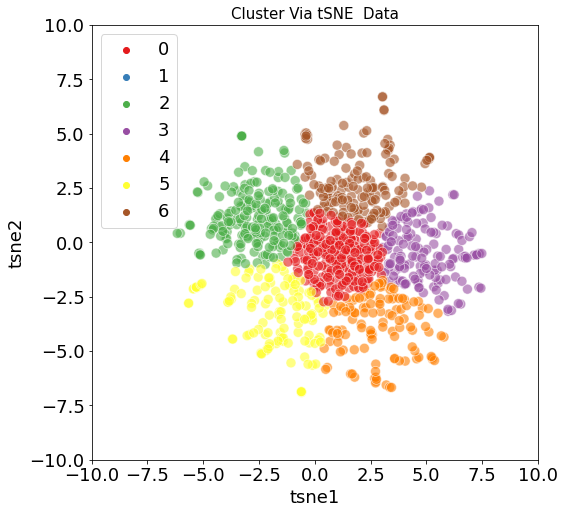

In [35]:
#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.legend()
plt.show()

#### <span class="bg-warning"> 3.1.4 Mesure de la qualité de la classification : ARI<span> 

In [36]:
#Metrics ARI
df_image['cluster_SIFT'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_SIFT']
from sklearn import metrics
ari_SIFT = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

Adjusted Rand Index: 0.033


#### <span class="bg-warning"> 3.1.5 Matrice de confusion<span>  

In [37]:
df_image.groupby('cluster_SIFT')['cat_1'].value_counts().to_frame();

In [38]:
df_image['cluster_SIFT_label'] = df_image['cluster_SIFT']
df_image['cluster_SIFT_label'] = df_image['cluster_SIFT_label'].replace(0, 'Beauty and Personal Care')
df_image['cluster_SIFT_label'] = df_image['cluster_SIFT_label'].replace(1, 'Computers')
df_image['cluster_SIFT_label'] = df_image['cluster_SIFT_label'].replace(2, 'Home Decor & Festive Needs')
df_image['cluster_SIFT_label'] = df_image['cluster_SIFT_label'].replace(3, 'Watches')
df_image['cluster_SIFT_label'] = df_image['cluster_SIFT_label'].replace(4, 'Home Furnishing')
df_image['cluster_SIFT_label'] = df_image['cluster_SIFT_label'].replace(5, 'Kitchen & Dining')
df_image['cluster_SIFT_label'] = df_image['cluster_SIFT_label'].replace(6, 'Baby Care')
categories_predict = df_image['cluster_SIFT_label']
categories_true = df_image['cat_1']

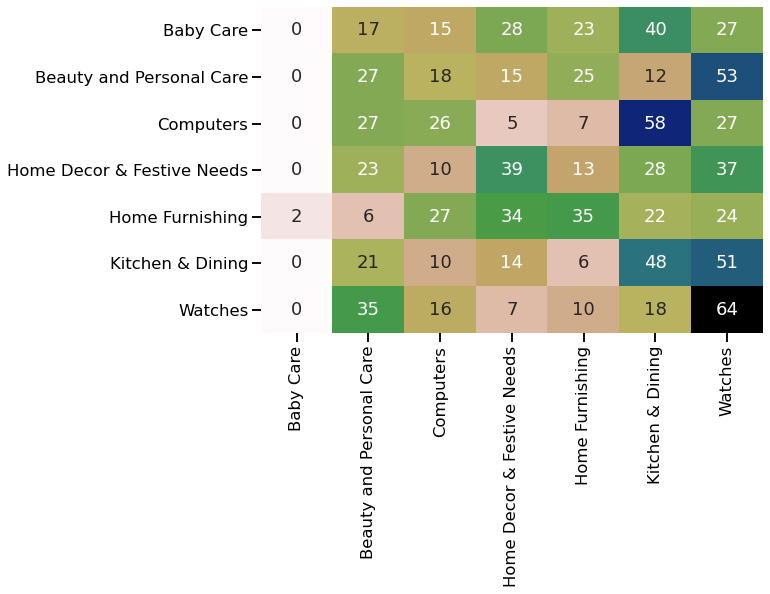


accuracy du clustering: 22.76%

accuracy de la classification: 14.29%
                            precision    recall  f1-score   support

                 Baby Care       0.11      0.11      0.11       150
  Beauty and Personal Care       0.19      0.35      0.24       150
                 Computers       0.00      0.00      0.00       150
Home Decor & Festive Needs       0.12      0.19      0.15       150
           Home Furnishing       0.29      0.23      0.26       150
          Kitchen & Dining       0.08      0.07      0.07       150
                   Watches       0.05      0.05      0.05       150

                  accuracy                           0.14      1050
                 macro avg       0.12      0.14      0.13      1050
              weighted avg       0.12      0.14      0.13      1050



In [39]:
heatconmat(categories_true, categories_predict) 

### <span class="bg-success"> 3.2 Algorithme ORB<span>  

#### <span class="bg-warning"> 3.2.1 Détection<span>  

In [40]:
# Descriptor_list
descriptor_list = []

images = df_image["image_OCV"]
lien_im_des = [] #lien image _ descripteur

for i in range(len(images)) :
    im = images[i]
    des = getDescriptors(orb, im)
    descriptor_list.append(des)
    
    # Lien image - descripteur
    for j in range(len(des)):
        lien_im_des.append(i)
    
descriptors = vstackDescriptors(descriptor_list)

#https://docs.opencv.org/master/d1/d5c/tutorial_py_kmeans_opencv.html
#samples : It should be of np.float32 data type, and each feature should be put in a single column.
descriptors = np.float32(descriptors)

#### <span class="bg-warning"> 3.1.1 Extraction<span>  

__K-means__

In [41]:
# Define criteria = ( type, max_iter = 10 , epsilon = 1.0 )
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)

# Set flags (Just to avoid line break in the code)
flags = cv2.KMEANS_PP_CENTERS #kmeans++

# Apply KMeans
# attempt : Indicateur permettant de spécifier le nombre de fois que l'algorithme est exécuté en utilisant différents libellés
# initiaux. L'algorithme renvoie les étiquettes qui donnent la meilleure compacité (voir le dernier paramètre de la fonction).
compactness,labels,centers = cv2.kmeans(descriptors,1000,None,criteria,1,flags)

In [42]:
data_images = []
for i in range(len(images)):
    # create a numpy to hold the histogram for each image
    data_images.insert(i, np.zeros((1000, 1)))

__Histogramme__

In [43]:
# Histograms from labels
size = labels.shape[0] * labels.shape[1]
data_images = []
for i in range(len(images)):
    # create a numpy to hold the histogram for each image
    data_images.insert(i, np.zeros((1000, 1)))
    
#Bag of visual words with SIFT
df_image["BOVW_ORB"] = ""
for i in range(size):
    label = labels[i]
    # Get this descriptors image id
    image_id = lien_im_des[i]
    # data_images is a list of the same size as the number of images
    images_data = data_images[image_id]
    # data is a numpy array of size (dictionary_size, 1) filled with zeros
    images_data[label] += 1
    df_image["BOVW_ORB"][image_id] = images_data.flatten()

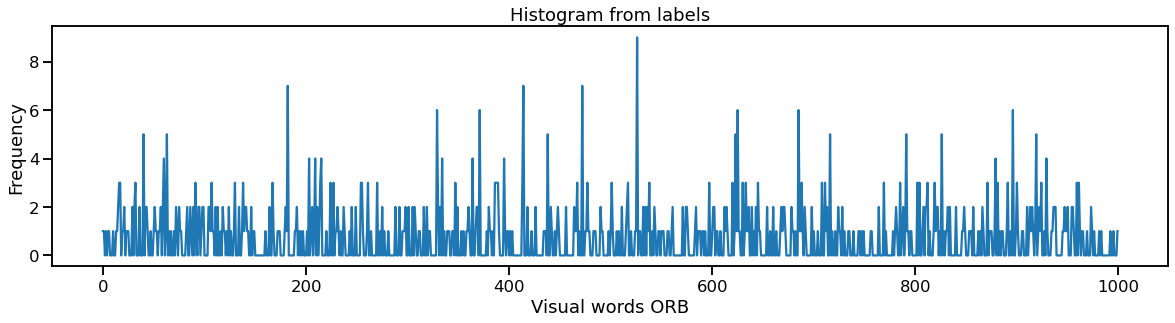

In [44]:
plt.figure(figsize=(20,15))
ax = plt.subplot(311)
ax.set_title("Histogram from labels")
ax.set_xlabel("Visual words ORB")
ax.set_ylabel("Frequency")
ax.plot(data_images[1].ravel())

#### <span class="bg-warning"> 3.1.1 Reduction de dimension et clustering<span> 

In [45]:
df_BOVW_ORB = extract_data("BOVW_ORB")
print("Taille vecteurs bovw ORB :", df_BOVW_ORB.shape[1])

Taille vecteurs bovw ORB : 1000


In [46]:
#Dimensions reduction Tsne
tsne = TSNE(n_components=2, verbose=0, perplexity=80, n_iter=5000, learning_rate=200)
tsne = tsne.fit_transform(df_BOVW_ORB)
tsne_df = pd.DataFrame(tsne, columns=['tsne1', 'tsne2'])

In [47]:
#Clustering kmeans
kmeans = KMeans(n_clusters=7, n_init=100, max_iter=400, init='k-means++', random_state=42).fit(tsne_df)
labels = kmeans.labels_
clusters = pd.concat([tsne_df, pd.DataFrame({'tsne_clusters':labels})], axis=1)

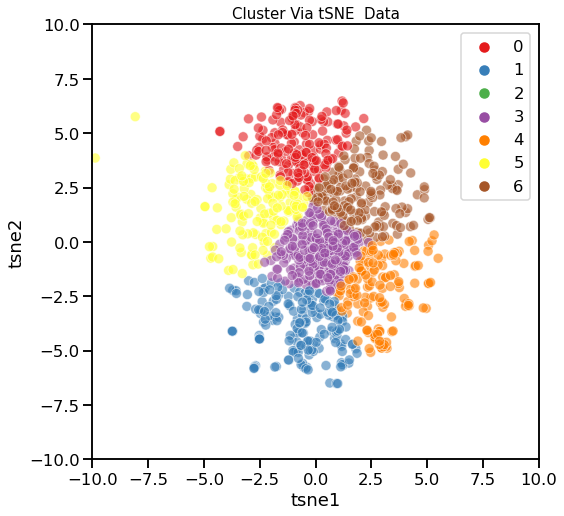

In [48]:
#Plotting
plt.figure(figsize = (8,8))
sns.scatterplot(clusters.iloc[:,0],clusters.iloc[:,1],hue=labels, palette='Set1', s=100, alpha=0.6).set_title('Cluster Via tSNE  Data', fontsize=15)
plt.xlim(-10,10)
plt.ylim(-10,10)
plt.legend()
plt.show()

#### <span class="bg-warning"> 3.1.4 Mesure de la qualité de la classification : ARI<span> 

In [49]:
#Metrics ARI
df_image['cluster_ORB'] = labels
categories_true = df_image['cat_1']
categories_predict = df_image['cluster_ORB']
from sklearn import metrics
ari_SIFT = metrics.adjusted_rand_score(categories_true, categories_predict)
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(categories_true, categories_predict))

Adjusted Rand Index: 0.041


#### <span class="bg-warning"> 3.1.5 Matrice de confusion<span>  

In [50]:
df_image.groupby('cluster_ORB')['cat_1'].value_counts().to_frame();

In [51]:
df_image['cluster_ORB_label'] = df_image['cluster_ORB']
df_image['cluster_ORB_label'] = df_image['cluster_ORB_label'].replace(0, 'Beauty and Personal Care')
df_image['cluster_ORB_label'] = df_image['cluster_ORB_label'].replace(1, 'Watches')
df_image['cluster_ORB_label'] = df_image['cluster_ORB_label'].replace(2, 'Home Decor & Festive Needs')
df_image['cluster_ORB_label'] = df_image['cluster_ORB_label'].replace(3, 'Kitchen & Dining')
df_image['cluster_ORB_label'] = df_image['cluster_ORB_label'].replace(4, 'Computers')
df_image['cluster_ORB_label'] = df_image['cluster_ORB_label'].replace(5, 'Home Furnishing')
df_image['cluster_ORB_label'] = df_image['cluster_ORB_label'].replace(6, 'Baby Care')
categories_predict = df_image['cluster_ORB_label']
categories_true = df_image['cat_1']

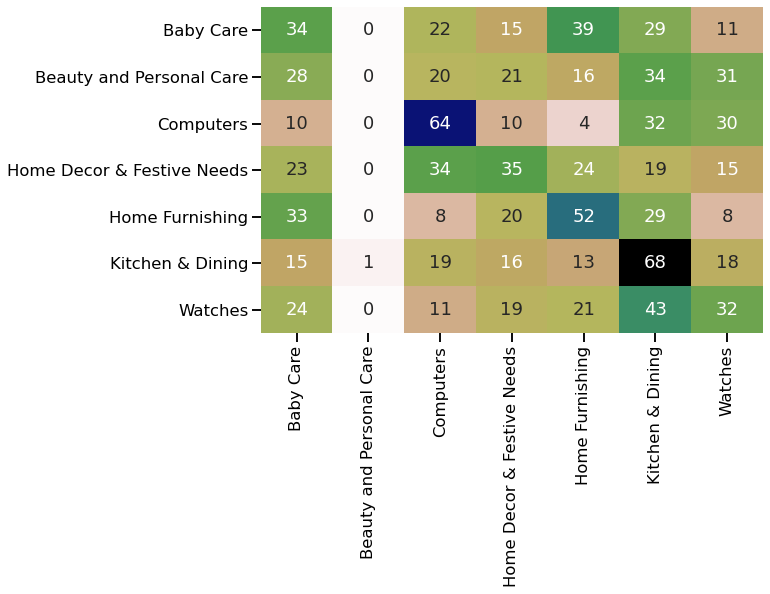


accuracy du clustering: 27.14%

accuracy de la classification: 17.05%
                            precision    recall  f1-score   support

                 Baby Care       0.20      0.23      0.21       150
  Beauty and Personal Care       0.09      0.11      0.10       150
                 Computers       0.21      0.20      0.20       150
Home Decor & Festive Needs       0.00      0.00      0.00       150
           Home Furnishing       0.15      0.13      0.14       150
          Kitchen & Dining       0.27      0.45      0.34       150
                   Watches       0.06      0.07      0.07       150

                  accuracy                           0.17      1050
                 macro avg       0.14      0.17      0.15      1050
              weighted avg       0.14      0.17      0.15      1050



In [52]:
heatconmat(categories_true, categories_predict) 